In [298]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [336]:
class LINBandit:
    def __init__(self, n_arms, n_contexts, d) -> None:
        self.n_arms = n_arms
        self.n_contexts = n_contexts
        self.d = d

        self.reset()

    def duel(self, arm1, arm2):
        # retun 1 with probability p if arm1 > arm2, 0 otherwise
        actual_feature = self.arms[self.context, arm1] - self.arms[self.context, arm2]
        pp = np.exp(np.dot(actual_feature, self.theta))
        p = pp / (1 + pp)
        obs = np.random.choice([0, 1], p=[1 - p, p])

        self.context = np.random.randint(0, self.n_contexts)
        return obs, self.context

    def reset(self):
        # set arms features randomly
        self.arms = np.random.normal(size=(self.n_contexts, self.n_arms, self.d))

        # set the hidden variable randomly
        self.theta = np.random.normal(size=(self.d))

        # set the current context
        self.context = np.random.randint(0, self.n_contexts)

        return self.context

In [337]:
def interact(
    env,
    ALG,
    n_steps=1000,
    n_arms=5,
    n_contexts=2,
    d=1,
):
    alg = ALG(n_arms=n_arms, n_contexts=n_contexts, d=d)
    context = env.context
    alg.reset(arms=env.arms)
    for i in range(n_steps):
        arm1, arm2 = alg.get_arms(context)
        previous_context = context
        result, context = env.duel(arm1, arm2)
        alg.update(previous_context, arm1, arm2, result)
        if i % 100 == 0:
            print(f"Step {i}: {ALG.__name__}")
    return alg

In [338]:
class Uniform:
    def __init__(self, n_arms, n_contexts, d):
        self.n_arms = n_arms
        self.n_contexts = n_contexts
        self.d = d

    def reset(self, arms):
        self.arms = arms
        self.features = []
        self.observations = []
        self.thetas = []

    def get_arms(self, context):
        # Record estimates for plotting
        if len(self.features) >= 10:
            self.thetas.append(self.get_theta_hat())

        # Selects two arms uniformly at random
        arms = np.random.choice(self.n_arms, 2, replace=False)
        return arms[0], arms[1]

    def update(self, context, arm1, arm2, observation):
        arms = self.arms[context, arm1], self.arms[context, arm2]
        self.features.append(arms[0] - arms[1])
        self.observations.append(observation)

    def get_theta_hat(self):
        # Returns the policy that finds the arm with the highest mean reward using logistic regression
        features = np.array(self.features)
        observations = np.array(self.observations)

        # Fit logistic regression
        lr = LogisticRegression(
            fit_intercept=False,
            penalty=None,
            solver="newton-cholesky",
            max_iter=1000,
            multi_class="ovr",
        )
        lr.fit(features, observations)
        return lr.coef_[0]

    def get_final_policy(self):
        theta_hat = self.get_theta_hat()

        def policy(context):
            # Returns the arm with the highest mean reward
            arms = self.arms[context]
            return np.argmax(np.dot(arms, theta_hat))

        return policy

In [339]:
class UniformWithArgmax(Uniform):
    def get_arms(self, context):
        if len(self.features) < 10:
            # Call parent method if no data has been collected yet
            return super().get_arms(context)

        theta = self.get_theta_hat()
        self.thetas.append(theta)

        # Selects the arm with the highest estimated reward for the given context
        arms = self.arms[context]
        arm1 = np.argmax(arms @ theta)

        # Selects an arm uniformly at random from the remaining arms
        arm2 = np.random.choice(np.setdiff1d(range(self.n_arms), arm1))
        return arm1, arm2

In [340]:
n_arms = 5
n_contexts = 2
d = 1
env = LINBandit(n_arms=n_arms, n_contexts=n_contexts, d=d)
steps = 10000

uni = interact(env, Uniform, n_steps=steps)
uniarg = interact(env, UniformWithArgmax, n_steps=steps)

Step 0: Uniform
Step 100: Uniform
Step 200: Uniform
Step 300: Uniform
Step 400: Uniform
Step 500: Uniform
Step 600: Uniform
Step 700: Uniform
Step 800: Uniform
Step 900: Uniform
Step 1000: Uniform
Step 1100: Uniform
Step 1200: Uniform
Step 1300: Uniform
Step 1400: Uniform
Step 1500: Uniform
Step 1600: Uniform
Step 1700: Uniform
Step 1800: Uniform
Step 1900: Uniform
Step 2000: Uniform
Step 2100: Uniform
Step 2200: Uniform
Step 2300: Uniform
Step 2400: Uniform
Step 2500: Uniform
Step 2600: Uniform
Step 2700: Uniform
Step 2800: Uniform
Step 2900: Uniform
Step 3000: Uniform
Step 3100: Uniform
Step 3200: Uniform
Step 3300: Uniform
Step 3400: Uniform
Step 3500: Uniform
Step 3600: Uniform
Step 3700: Uniform
Step 3800: Uniform
Step 3900: Uniform
Step 4000: Uniform
Step 4100: Uniform
Step 4200: Uniform
Step 4300: Uniform
Step 4400: Uniform
Step 4500: Uniform
Step 4600: Uniform
Step 4700: Uniform
Step 4800: Uniform
Step 4900: Uniform
Step 5000: Uniform
Step 5100: Uniform
Step 5200: Uniform
Step 

In [341]:
print("UNIFORM:", uni.thetas[-1])
print("ARGMAX:", uniarg.thetas[-1])
print("True theta:", env.theta)

UNIFORM: [-1.32646795]
ARGMAX: [-1.35980283]
True theta: [-1.34259335]


In [342]:
# Plot the convergence of the thetas to the true theta
plt.rcParams["text.usetex"] = True


def plot_progress(true_theta, algs):
    distances = []
    for alg in algs:
        distance = []
        # distance.append([np.linalg.norm(theta - true_theta) for theta in alg.thetas])
        # distances.append(distance)
        distances.append(alg.thetas)
    plt.figure(figsize=(10, 8))
    for i, distance in enumerate(distances):
        print(i)
        plt.plot(distance, label=algs[i].__class__.__name__)

    # Plot true theta as a horizontal line
    plt.axhline(y=true_theta, color="black", linestyle="--")

    plt.xlabel("Iteration")
    plt.ylabel(r"$\hat \theta$", fontsize=16)
    plt.legend()
    plt.show()

0
1


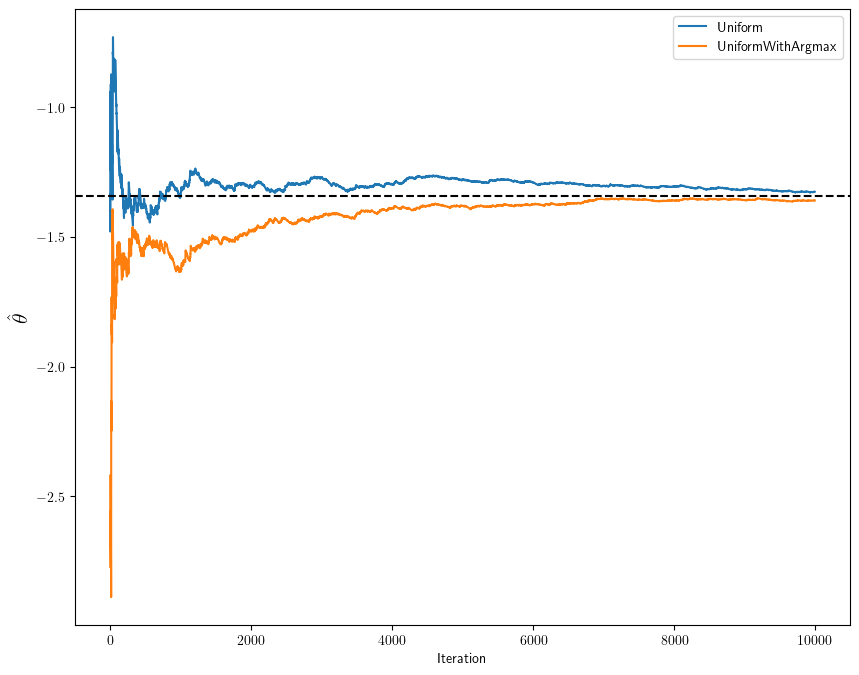

In [343]:
plot_progress(env.theta, [uni, uniarg])

In [202]:
len(uniarg.thetas)

19981